# This is an implementation of the fitness evaluation function used in the paper in order to demonstrate how fitness functions work 

from paper : *Genetic Programming as a Means for Programming Computers by Natural Selection*
by John R. Koza

In [1]:
import numpy as np
import math

### Expression Evaluation Library by Norvig (  lisp interpreter in python used to evaluate our prefix S-expressions)

In [2]:
################ Lispy: Scheme Interpreter in Python 3.3+

## (c) Peter Norvig, 2010-18; See http://norvig.com/lispy.html

################ Imports and Types

import math
import operator as op
from collections import ChainMap as Environment

Symbol = str          # A Lisp Symbol is implemented as a Python str
List   = list         # A Lisp List   is implemented as a Python list
Number = (int, float) # A Lisp Number is implemented as a Python int or float

class Procedure(object):
    "A user-defined Scheme procedure."
    def __init__(self, parms, body, env):
        self.parms, self.body, self.env = parms, body, env
    def __call__(self, *args):
        env =  Environment(dict(zip(self.parms, args)), self.env)
        return eval(self.body, env)

################ Global Environment

def standard_env():
    "An environment with some Scheme standard procedures."
    env = {}
    env.update(vars(math)) # sin, cos, sqrt, pi, ...
    env.update({
        '+':op.add, '-':op.sub, '*':op.mul, '/':op.truediv, 
        '>':op.gt, '<':op.lt, '>=':op.ge, '<=':op.le, '=':op.eq, 
        'abs':     abs,
        'append':  op.add,  
        'apply':   lambda proc, args: proc(*args),
        'begin':   lambda *x: x[-1],
        'car':     lambda x: x[0],
        'cdr':     lambda x: x[1:], 
        'cons':    lambda x,y: [x] + y,
        'eq?':     op.is_, 
        'equal?':  op.eq, 
        'length':  len, 
        'list':    lambda *x: list(x), 
        'list?':   lambda x: isinstance(x,list), 
        'map':     lambda *args: list(map(*args)),
        'max':     max,
        'min':     min,
        'not':     op.not_,
        'null?':   lambda x: x == [], 
        'number?': lambda x: isinstance(x, Number),   
        'procedure?': callable,
        'round':   round,
        'symbol?': lambda x: isinstance(x, Symbol),
    })
    return env

global_env = standard_env()

################ Parsing: parse, tokenize, and read_from_tokens

def parse(program):
    "Read a Scheme expression from a string."
    return read_from_tokens(tokenize(program))

def tokenize(s):
    "Convert a string into a list of tokens."
    return s.replace('(',' ( ').replace(')',' ) ').split()

def read_from_tokens(tokens):
    "Read an expression from a sequence of tokens."
    if len(tokens) == 0:
        raise SyntaxError('unexpected EOF while reading')
    token = tokens.pop(0)
    if '(' == token:
        L = []
        while tokens[0] != ')':
            L.append(read_from_tokens(tokens))
        tokens.pop(0) # pop off ')'
        return L
    elif ')' == token:
        raise SyntaxError('unexpected )')
    else:
        return atom(token)

def atom(token):
    "Numbers become numbers; every other token is a symbol."
    try: return int(token)
    except ValueError:
        try: return float(token)
        except ValueError:
            return Symbol(token)

################ Interaction: A REPL

def repl(prompt='lis.py> '):
    "A prompt-read-eval-print loop."
    while True:
        val = eval(parse(input(prompt)))
        if val is not None:
            print(lispstr(val))

def lispstr(exp):
    "Convert a Python object back into a Lisp-readable string."
    if isinstance(exp, List):
        return '(' + ' '.join(map(lispstr, exp)) + ')' 
    else:
        return str(exp)

################ eval


def eval(x, env=global_env):
    "Evaluate an expression in an environment."
    if isinstance(x, Symbol):      # variable reference
        return env[x]
    elif not isinstance(x, List):  # constant literal
        return x                
    elif x[0] == 'quote':          # (quote exp)
        (_, exp) = x
        return exp
    elif x[0] == 'if':             # (if test conseq alt)
        (_, test, conseq, alt) = x
        exp = (conseq if eval(test, env) else alt)
        return eval(exp, env)
    elif x[0] == 'define':         # (define var exp)
        (_, var, exp) = x
        env[var] = eval(exp, env)
    elif x[0] == 'lambda':         # (lambda (var...) body)
        (_, parms, body) = x
        return Procedure(parms, body, env)
    else:                          # (proc arg...)
        proc = eval(x[0], env)
        args = [eval(exp, env) for exp in x[1:]]
        return proc(*args)

In [3]:
# Minor addition
# Parse and evaluate merged into a single function
def pe(x):
    return eval(parse(x))

In [4]:
pe('(begin (define x 3) (define y 4) (+ x (+ 1 y)))') #sample prefix expression written in Lisp(scheme)

8

# Task implementation: symbolic regression of noisy numeric-valued empirical data

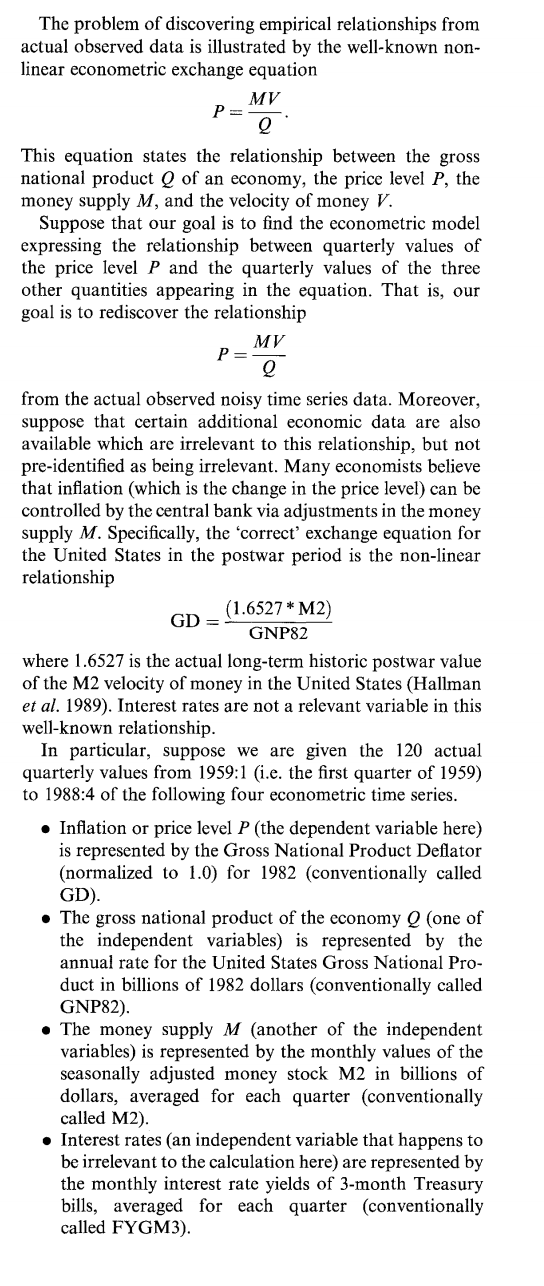

### Define Function to be Discovered

In [5]:
# Function to be discover using genetic program :  (koza paper)

def eq(M2,GNP82):
    # M2 is money supply in billions of dollars
    GD=(1.6527*M2)/GNP82
    return GD

### Data Generation

In [6]:
N=5000 # number of data points

# Create N Data Points
np.random.seed(11)

data=[]
for i in range(N):
    m2=np.random.uniform(-1,1)
    gnp=np.random.uniform(-1,1)
    gd=eq(m2,gnp)
    
    data.append([m2,gnp,gd])

print('total data:',len(data))
print()
print('sample')
print(['m2','gnp','gd'])
for record in data[:5]:
    print(record)

trainingdata=data[:3000]
testdata=data[3000:]

print()
print('training data:',len(trainingdata))
print('test data:',len(testdata))

total data: 5000

sample
['m2', 'gnp', 'gd']
[-0.6394606222464616, -0.9610495170247508, 1.0996692175222325]
[-0.07356294700331079, 0.44986785838429566, -0.27025154219512]
[-0.15959279082454514, -0.0291458036644352, 9.049639132702126]
[-0.9744383708187827, -0.025256785360256773, 63.763233225490325]
[0.8836133046867323, 0.7015901787535574, 2.0814825419167224]

training data: 3000
test data: 2000


### Fitness Evaluation Function

In [7]:
# Calcuates fitness using MSE for a given equation(in form of a Lisp like S-expression) using given data
def fitness_function(equation,data):
    
    # Define initial error
    rsse=0 #squared root of sum of squared errors
    sumofse=0

    # Go over each record in given data
    for record in data:
        
        # Get M2,GNP82 (we assume that an ephemeral R is part of the tree structure) for given data     
        m=record[0]
        gnp=record[1]
        actualgd=record[2]
        
        # Fill the M2 and GNP82 values for this record in the given equation
        # assumption is 
            # M2's value placeholder will be marked as M2Value in the equation string
            # GNP82' value placeholder will be marked as GNP82Value in the equation string
        recordEquation=equation.replace('GNP82Value',str(gnp))
        recordEquation=recordEquation.replace('M2Value',str(m))
        
        # Evaluate the equation using Norvig's functions
        predictedgd=pe(recordEquation)
        
        # Calculate mean square error
        sumofse+=(predictedgd-actualgd)*(predictedgd-actualgd)
    
    rsse=math.sqrt(float(sumofse))
    
    # return the mse calculated on entire given data using the given equation
    return rsse



In [8]:
# evaluate fitness of correct equation using training data
fitness_function('(begin (define m2 M2Value) (define gnp GNP82Value) (* 1.6527 (/ m2 gnp) ))',trainingdata)

8.127846139455242e-14

In [9]:
# evaluate fitness of correct equation using test data
fitness_function('(begin (define m2 M2Value) (define gnp GNP82Value) (* 1.6527 (/ m2 gnp) ))',testdata)

7.388859724730954e-14

In [10]:
# evaluate fitness of correct equation using training data
fitness_function('(begin (define m2 M2Value) (define gnp GNP82Value) ( * m2 gnp ))',trainingdata)

3323.608349554733

In [11]:
# evaluate fitness of correct equation using test data
fitness_function('(begin (define m2 M2Value) (define gnp GNP82Value) ( * m2 gnp))',testdata)

2496.9437091517466